In [100]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [2]:
import sys
sys.path.insert(0,'../..')

### Loading Libraries

In [297]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import roc_curve
from keras.layers import Flatten
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Dropout
from keras.models import Model
import matplotlib.pyplot as plt
import keras
from keras.applications import ResNet101, DenseNet121, VGG19
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint , EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
from utils import metainfo_df, sampled_df, load_data, images_to_arrays, plot_confusion_matrix

In [5]:
TRAIN_PATH = r'C:\Users\JohanR\Downloads\Chest_Xray_Covid_pneumonia\Datav0\train'
TEST_PATH = r'C:\Users\JohanR\Downloads\Chest_Xray_Covid_pneumonia\Datav0\test'
#img_size=224

### Dataframe info

In [29]:
train_df = metainfo_df(TRAIN_PATH)

Text(0, 0.5, 'Freq')

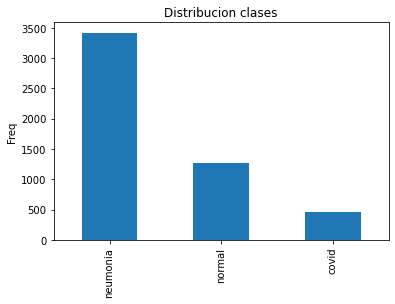

In [30]:
train_df['label'].value_counts().plot.bar()
plt.xticks([0,1,2],labels=['neumonia','normal','covid']);
plt.title('Distribucion clases')
plt.ylabel('Freq')

In [31]:
# Check the correct dataframe structure
print('COVID files:',train_df[train_df['filename'].str.contains('COVID')].shape)
print('NORMAL files:',train_df[train_df['filename'].str.contains('NORMAL')].shape)
print('NEUMONIA files:',train_df[train_df['filename'].str.contains('NEUMONIA')].shape)

COVID files: (460, 2)
NORMAL files: (1266, 2)
NEUMONIA files: (3418, 2)


In [32]:
df_data = sampled_df(train_df)
df_covnorm = df_data[df_data['label'].isin(['0','1'])]
df_covnorm.sample(5)

,filename,label
386,COVID19(446).jpg,0
1168,NORMAL(497).jpg,1
452,COVID19(92).jpg,0
313,COVID19(380).jpg,0
774,NORMAL(141).jpg,1


In [33]:
print('samples in covnorm: ', df_covnorm.shape)
print('samples covid: ', df_covnorm[df_covnorm['label'] == '0'].shape)
print('samples normal : ', df_covnorm[df_covnorm['label'] == '1'].shape)

samples in covnorm:  (920, 2)
samples covid:  (460, 2)
samples normal :  (460, 2)


#### Test dataset

In [34]:
test_df = metainfo_df(TEST_PATH)
test_covnorm = test_df[test_df['label'].isin(['0','1'])]

In [35]:
print('samples in covnorm: ', test_covnorm.shape)
print('samples covid: ', test_covnorm[test_covnorm['label'] == '0'].shape)
print('samples normal : ', test_covnorm[test_covnorm['label'] == '1'].shape)

samples in covnorm:  (433, 2)
samples covid:  (116, 2)
samples normal :  (317, 2)


### Loading data

In [36]:
train_data = load_data(TRAIN_PATH)
test_data =  load_data(TEST_PATH)

In [37]:
X_train,y_train = images_to_arrays(train_data)
X_test, y_test = images_to_arrays(test_data)

In [38]:
# Extract a sample
idx = df_covnorm.index.tolist()
X_train_sample = X_train[idx] / 255.
y_train_sample = y_train[idx]

In [39]:
# Extract a sample
idx = test_covnorm.index.tolist()
X_test = X_test[idx] / 255.
y_test = y_test[idx]

In [40]:
# perform one-hot encoding on the labels
lb_test = LabelBinarizer()
test_labels = lb_test.fit_transform(y_test)
test_labels = to_categorical(y_test)

### Modelling

In [323]:
base_model ={
    'densenet': DenseNet121(include_top=False,input_shape=(224,224,3),weights='imagenet'),
    'resnet101': ResNet101(include_top=False,input_shape=(224,224,3),weights='imagenet')
}

In [324]:
def create_new_model(model_name = 'densenet'):
    model = base_model[model_name]
    # Fix layers pretained
    for layer in model.layers:
        layer.trainable= False
    # add extra layers
    x = Flatten()(model.output)
    x = Dense(512, activation ='relu')(x)
    x = Dropout(0.1)(x)
    prediction = Dense(2,activation='sigmoid')(x)
    new_model = Model(inputs=model.input, outputs=prediction)
    return new_model

In [325]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train_sample)
train_labels = to_categorical(y_train_sample)

In [326]:
trainX, testX, trainY, testY = train_test_split(X_train_sample, train_labels,test_size=0.20, stratify=train_labels, random_state=42)

In [327]:
print('train_data shape: ', trainX.shape)
print('test_data shape: ', testX.shape)

train_data shape:  (736, 224, 224, 3)
test_data shape:  (184, 224, 224, 3)


In [328]:
prop_train =  np.count_nonzero(trainY.argmax(axis=1)) / np.where(trainY.argmax(axis=1) <1)[0].shape[0]
prop_test = np.count_nonzero(testY.argmax(axis=1)) / np.where(testY.argmax(axis=1)<1)[0].shape[0]
print('proportion covid/normal for train_dataset:', prop_train)
print('proportion covid/normal for test_dataset:', prop_test)

proportion covid/normal for train_dataset: 1.0
proportion covid/normal for test_dataset: 1.0


In [329]:
# initialize the training data augmentation object
train_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()

In [330]:
model = create_new_model('resnet101')

In [331]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy',keras.metrics.Recall(),
                                                                         keras.metrics.Precision(),
                                                                         keras.metrics.SpecificityAtSensitivity(0.7),
                                                                        keras.metrics.SensitivityAtSpecificity(0.5)])

In [332]:
model.summary()

Model: "functional_91"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

conv4_block11_3_conv (Conv2D)   (None, 14, 14, 1024) 263168      conv4_block11_2_relu[0][0]       
__________________________________________________________________________________________________
conv4_block11_3_bn (BatchNormal (None, 14, 14, 1024) 4096        conv4_block11_3_conv[0][0]       
__________________________________________________________________________________________________
conv4_block11_add (Add)         (None, 14, 14, 1024) 0           conv4_block10_out[0][0]          
                                                                 conv4_block11_3_bn[0][0]         
__________________________________________________________________________________________________
conv4_block11_out (Activation)  (None, 14, 14, 1024) 0           conv4_block11_add[0][0]          
__________________________________________________________________________________________________
conv4_block12_1_conv (Conv2D)   (None, 14, 14, 256)  262400      conv4_block11_out[0][0]          
__________

conv5_block3_1_relu (Activation (None, 7, 7, 512)    0           conv5_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block3_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block3_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block3_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block3_2_relu (Activation (None, 7, 7, 512)    0           conv5_block3_2_bn[0][0]          
__________________________________________________________________________________________________
conv5_block3_3_conv (Conv2D)    (None, 7, 7, 2048)   1050624     conv5_block3_2_relu[0][0]        
__________________________________________________________________________________________________
conv5_bloc

In [333]:
## ADD CALLBACKS
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=2,
                               verbose=1,
                               min_lr=0.5e-6)

earlyStop_criterio =EarlyStopping(monitor="val_loss",
                                      patience=2,verbose=1,mode="auto")
model_callbacks = [lr_reducer,earlyStop_criterio]

In [334]:
BS = 32
EPOCHS = 5

In [335]:
history = model.fit(train_gen.flow(trainX, trainY, batch_size=BS),
                        steps_per_epoch=len(trainX) // BS,validation_data=(testX, testY),
                        validation_steps=len(testX) // BS,epochs=EPOCHS)

Epoch 1/5
23/23 [==============================] - 138s 6s/step - loss: 3.0783 - accuracy: 0.7188 - recall_1: 0.6155 - precision_1: 0.6353 - specificity_at_sensitivity_1: 0.5761 - sensitivity_at_specificity_1: 0.8084 - val_loss: 0.6212 - val_accuracy: 0.8859 - val_recall_1: 0.9457 - val_precision_1: 0.6421 - val_specificity_at_sensitivity_1: 0.9620 - val_sensitivity_at_specificity_1: 0.9402
Epoch 2/5
23/23 [==============================] - 125s 5s/step - loss: 0.3424 - accuracy: 0.9103 - recall_1: 0.9185 - precision_1: 0.8711 - specificity_at_sensitivity_1: 0.9715 - sensitivity_at_specificity_1: 0.9878 - val_loss: 0.1932 - val_accuracy: 0.9293 - val_recall_1: 0.9293 - val_precision_1: 0.9194 - val_specificity_at_sensitivity_1: 0.9891 - val_sensitivity_at_specificity_1: 0.9946
Epoch 3/5
23/23 [==============================] - 137s 6s/step - loss: 0.2605 - accuracy: 0.9117 - recall_1: 0.9008 - precision_1: 0.9107 - specificity_at_sensitivity_1: 0.9810 - sensitivity_at_specificity_1: 0.

<Figure size 432x288 with 0 Axes>

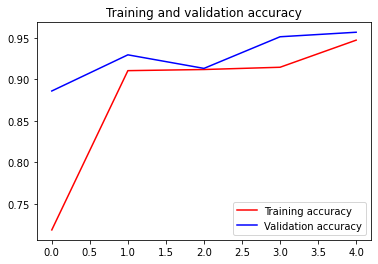

<Figure size 432x288 with 0 Axes>

In [336]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

<Figure size 432x288 with 0 Axes>

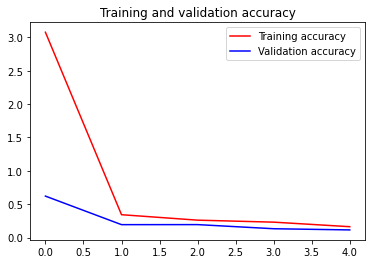

<Figure size 432x288 with 0 Axes>

In [337]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

### Predict on testset

Evaluamos sobre el conjunto de test que el modelo no ha visto anteriormente.

In [338]:
predict = model.predict(X_test)

In [339]:
y_pred = predict.argmax(axis=1)
y_real = test_labels.argmax(axis=1)

In [340]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(y_real, y_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[112   4]
 [ 15 302]]
acc: 0.9561
sensitivity: 0.9655
specificity: 0.9527


Confusion matrix, without normalization
[[112   4]
 [ 15 302]]


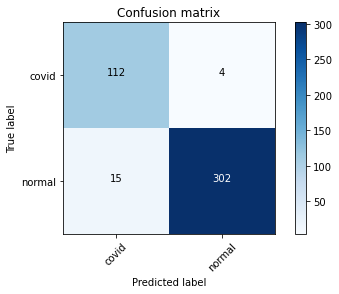

In [341]:
plot_confusion_matrix(cm,classes=['covid','normal'])

### ROC Curve

In [342]:
fpr, tpr, thresholds = roc_curve(y_real,y_pred)

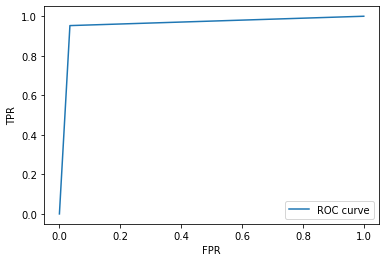

In [343]:
plt.plot(fpr, tpr, label='ROC curve');
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend();

In [344]:
print(classification_report(y_real,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       116
           1       0.99      0.95      0.97       317

    accuracy                           0.96       433
   macro avg       0.93      0.96      0.95       433
weighted avg       0.96      0.96      0.96       433



In [345]:
model.save_weights(r'C:\Users\JohanR\Downloads\Chest_Xray_Covid_pneumonia\models\modelbinary_resnet101.h5')